In [ ]:
!pip install pyqubo dimod dwave-ocean-sdk

In [2]:
from pyqubo import Array

n_pattern  = 7  # 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]、6:なし
lattice_size_x = 10
lattice_size_y = 10
v = Array.create('v', shape=(lattice_size_x, lattice_size_y, n_pattern), vartype='BINARY')


In [3]:
import numpy as np
def convert_to_np(result, var, var_label):
    result_np = np.zeros(var.shape, dtype=int)
    for x in range(var.shape[0]):
        for y in range(var.shape[1]):
            for p in range(var.shape[2]):
                label = f'{var_label}[{x}][{y}][{p}]'
                if label in result:
                    result_np[x][y][p] = result[label]
                else:
                    result_np[x][y][p] = 0
    success = result_np.sum() == var.shape[0] * var.shape[1]
    result_np = result_np.argmax(axis=-1)
    return success, result_np

In [4]:
import matplotlib.pyplot as plt

def plot(pattern_array, x_size, y_size):
    # 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
    show_positions = [
        {
            'from': [0.5, 1],
            'to': [0.5, 0]
        },
        {
            'from': [0, 0.5],
            'to': [1, 0.5]
        },
        {
            'from': [0.5, 1],
            'to': [1, 0.5]
        },
        {
            'from': [1, 0.5],
            'to': [0.5, 0]
        },
        {
            'from': [0.5, 0],
            'to': [0, 0.5]
        },
        {
            'from': [0, 0.5],
            'to': [0.5, 1]
        },
        None
    ]
    plt.xlim([0, x_size])
    plt.ylim([0, y_size])
    plt.xticks(list(range(x_size+1)))
    plt.yticks(list(range(y_size+1)))
    for x in range(x_size):
        for y in range(y_size):
            p = pattern_array[x][y]
            positions = show_positions[p]
            if positions is None:
                continue
            xs = [x + positions['from'][0], x + 0.5, x + positions['to'][0]]
            ys = [y + positions['from'][1], y + 0.5, y + positions['to'][1]]
            plt.plot(xs, ys)
    # plt.grid()

In [5]:
from pyqubo import Constraint

# 各地点で選べるパターンは一つだけ
H_onehot = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        tmp = 0
        for p in range(n_pattern):
            tmp += v[x][y][p]
        H_onehot += Constraint((tmp - 1)**2, str(x)+":"+str(y))

In [6]:
# スタート、ゴール地点を作成
endpoints = [
    [0, 0],
    [lattice_size_x - 1, lattice_size_y-1]
]

H_endpoint = 0
for endpoint in endpoints:
    x = endpoint[0]
    y = endpoint[1]
    H_endpoint -= v[x][y][6]  # must be 6(no edge)

In [7]:
# スタート、ゴール地点周辺との非接続へのペナルティ
n_endpoint_connect =1
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
endpoint_connect_patterns = [
        {
            "pos": [0, 1],
            "patterns": [0, 3, 4]
        },
        {
            "pos": [0, -1],
            "patterns": [0, 2, 5]
        },
        {
            "pos": [1, 0],
            "patterns": [1, 4, 5]
        },
        {
            "pos": [-1, 0],
            "patterns": [1, 2, 3]
        }
]
H_endpoint_unconnect = 0
for endpoint in endpoints:
    x = endpoint[0]
    y = endpoint[1]
    tmp = 0
    for endpoint_connect_pattern in endpoint_connect_patterns:
        target_x = x + endpoint_connect_pattern["pos"][0]
        target_y = y + endpoint_connect_pattern["pos"][1]
        if 0 <= target_x < lattice_size_x and 0 <= target_y < lattice_size_y:
            for p in endpoint_connect_pattern["patterns"]:
                tmp += v[target_x][target_y][p]
    H_endpoint_unconnect += (tmp - n_endpoint_connect) ** 2

In [8]:
def is_endpoints(x, y, endpoints):
    for endpoint in endpoints:
        if endpoint[0] == x and endpoint[1] == y:
            return True
    return False

In [9]:
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
unconnected_penalty_patterns = [
    [
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5, 6]
        },
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4, 6]
        }
    ],
    [
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5, 6]
        },
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3, 6]
        }
    ],
    [
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5, 6]
        },
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3, 6]
        }
    ],
    [
        {
            "pos": [1, 0],
            "patterns": [0, 2, 3, 6]
        },
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4, 6]
        }
    ],
    [
        {
            "pos": [0, -1],
            "patterns": [1, 3, 4, 6]
        },
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5, 6]
        }
    ],
    [
        {
            "pos": [-1, 0],
            "patterns": [0, 4, 5, 6]
        },
        {
            "pos": [0, 1],
            "patterns": [1, 2, 5, 6]
        }
    ],
    []
]

# 接続していなかったらペナルティ
H_unconnected = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        if is_endpoints(x, y, endpoints):
            continue
        for p in range(n_pattern):
            penalty_patterns = unconnected_penalty_patterns[p]
            for penalty_pattern in penalty_patterns:
                target_x = x + penalty_pattern["pos"][0]
                target_y = y + penalty_pattern["pos"][1]
                if is_endpoints(target_x, target_y, endpoints):
                    H_unconnected -= v[x][y][p] * v[target_x][target_y][6]
                if 0 <= target_x < lattice_size_x and 0 <= target_y < lattice_size_y:
                    for target_pattern in penalty_pattern["patterns"]:
                        H_unconnected += v[x][y][p] * v[target_x][target_y][target_pattern]

In [10]:
# 外部接続に対してペナルティ
# 0:[上、下]、1;[左、右]、2:[上、右]、3:[右、下]、4:[下、左]、5:[左、上]
penaltiy_patterns_outgoing = {
    "left": [1, 4, 5],
    "right": [1, 2, 3],
    "top": [0, 2, 5],
    "bottom": [0, 3, 4]
}
H_outgoing = 0
for y in range(lattice_size_y):
    # 左端
    for p in penaltiy_patterns_outgoing["left"]:
        H_outgoing += v[0][y][p]
    # 右端
    for p in penaltiy_patterns_outgoing["right"]:
        H_outgoing += v[lattice_size_x - 1][y][p]
for x in range(lattice_size_x):
    # 上端
    for p in penaltiy_patterns_outgoing["bottom"]:
        H_outgoing += v[x][0][p]
    # 下端
    for p in penaltiy_patterns_outgoing["top"]:
        H_outgoing += v[x][lattice_size_y - 1][p]


In [11]:
# 線があるときはペナルティ
H_line_penalty = 0
for x in range(lattice_size_x):
    for y in range(lattice_size_y):
        for p in range(n_pattern - 1):
            H_line_penalty += v[x][y][p]

True


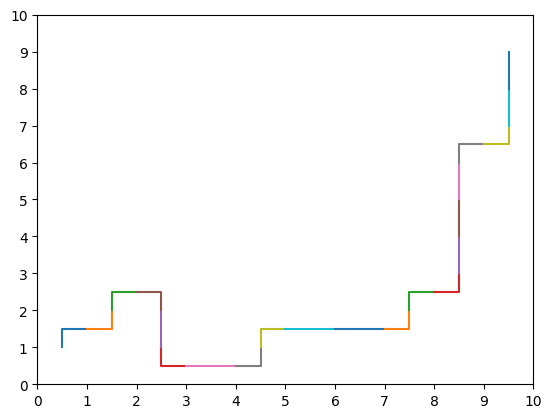

In [12]:
import dimod
S = 1
H = 0
H += H_onehot
H += H_unconnected
H += H_outgoing
H += H_endpoint
H += H_endpoint_unconnect
H += 0.1 * H_line_penalty # onehotよりは小さく
bqm = H.compile().to_bqm()
sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=10)
result = sampleset.first.sample

success, pattern_array = convert_to_np(result, v, "v")
print(success)
plot(pattern_array, lattice_size_x, lattice_size_y)

In [13]:
# # D-Waveを使いたい場合
# from dwave.system import LeapHybridSampler
# S = 1
# H = 0
# H += H_onehot
# H += H_unconnected
# H += H_outgoing
# H += H_endpoint
# H += H_endpoint_unconnect
# # H += 0.809/(lattice_size_x+lattice_size_y) * H_line_penalty # onehotよりは小さく  # 20x20まではこれ
# H += 0.52/(lattice_size_x+lattice_size_y) * H_line_penalty # onehotよりは小さく
# bqm = H.compile().to_bqm()

# # D-Wave leapにアカウント登録し、tokenを以下に記入すればD-Waveを利用できる。
# sampler = LeapHybridSampler(token="XXXXXXXXXX")
# sampleset = sampler.sample(bqm)  # bqmはdimodで作成したものが使える。
# result = sampleset.first.sample

# success, pattern_array = convert_to_np(result, v, "v")
# print(success)
# plot(pattern_array, lattice_size_x, lattice_size_y)